#### Importação

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
#from missforest import MissForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.manifold import trustworthiness
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture


#### metricas

In [76]:
def generate_data(df):
   continuo = ['age', 'bands', 'temp', 'lactate', 'WBC', 'lymphs',
               'resp', 'spo2/fio2', 'pao2/fio2', 'bicarbonate', 'heartRate',
               'troponin', 'systolic', 'diastolic', 'MAP', 'bloodUreaNitrogen',
               'alanine', 'aspartate', 'bilirubin', 'hemoglobin', 'iqr', 'platelets',
               'PTT', 'albumin', 'chloride', 'glucose', 'sodium', 'gcs', 'potassium',
               'calcium', 'phosphate', 'magnesium', 'sofascore']
   categorical = ['Gender','Ethnicity']
    
   # Z-score normalization para as features numéricas
   scaler = StandardScaler()
   features_scaled = scaler.fit_transform(df[continuo])

   # One-hot encoding para as features categóricas
   encoder = OneHotEncoder(drop='first', sparse_output=False)  # 'drop=first' para evitar a dummy trap
   categorical_encoded = encoder.fit_transform(df[categorical])

   # Criar DataFrames para as features normalizadas e codificadas
   features_final = pd.DataFrame(features_scaled, columns=continuo)
   categorical_final = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical))

   # Concatenar as features numéricas e categóricas
   final_data = pd.concat([features_final, categorical_final], axis=1)

   # Exibir o DataFrame final
   final_data

   return final_data

In [62]:
def generate_metrics(df, name_prefix):
    # Lista de números de clusters para testar
    k_values = range(2, 11)  # Testando de 2 a 10 clusters

    # Armazenar os resultados
    results = {
        'k': [],
        'Silhouette Score': [],
        'Intra Cluster Distance': [],
        'Inter Cluster Distance': [],
        'Davies-Bouldin Index': []
    }

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df)
        labels = kmeans.labels_
        
        # Calcular as métricas
        silhouette = silhouette_score(df, labels)
        davies_bouldin = davies_bouldin_score(df, labels)
        
        # Calcular distâncias intra e inter cluster
        intra_cluster_distances = []
        inter_cluster_distances = []
        
        for cluster in range(k):
            cluster_points = df[labels == cluster]
            if len(cluster_points) > 1:
                intra_cluster_distances.append(pairwise_distances(cluster_points).mean())
        
        intra_cluster_distance = np.mean(intra_cluster_distances) if intra_cluster_distances else np.nan
        
        # Distância média entre clusters
        for i in range(k):
            for j in range(i + 1, k):
                cluster_i = df[labels == i]
                cluster_j = df[labels == j]
                if len(cluster_i) > 0 and len(cluster_j) > 0:
                    distance = pairwise_distances(cluster_i, cluster_j).mean()
                    inter_cluster_distances.append(distance)
                    
        inter_cluster_distance = np.mean(inter_cluster_distances) if inter_cluster_distances else np.nan
        
        # Armazenar os resultados
        results['k'].append(k)
        results['Silhouette Score'].append(silhouette)
        results['Intra Cluster Distance'].append(intra_cluster_distance)
        results['Inter Cluster Distance'].append(inter_cluster_distance)
        results['Davies-Bouldin Index'].append(davies_bouldin)
    
    # Criar DataFrame com os resultados
    metrics_df = pd.DataFrame(results)
    metrics_df['Dataset'] = name_prefix
    
    # Plot do Silhouette Score
    plt.figure(figsize=(12, 6))
    plt.plot(results['k'], results['Silhouette Score'], 'o-', label='Silhouette Score', color='green')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score para Diferentes Valores de k - {name_prefix}')
    plt.legend()
    plt.show()
    
    return metrics_df

In [63]:
def generate_gmm_metrics(df, name_prefix):
    # Lista de números de clusters para testar
    k_values = range(2, 11)  # Testando de 2 a 10 clusters

    # Armazenar os resultados
    results = {
        'k': [],
        'Silhouette Score': [],
        'Intra Cluster Distance': [],
        'Inter Cluster Distance': [],
        'Davies-Bouldin Index': []
    }

    for k in k_values:
        gmm = GaussianMixture(n_components=k, random_state=42,covariance_type='spherical')
        gmm.fit(df)
        labels = gmm.predict(df)
        
        # Calcular as métricas
        silhouette = silhouette_score(df, labels)
        davies_bouldin = davies_bouldin_score(df, labels)
        
        # Calcular distâncias intra e inter cluster
        intra_cluster_distances = []
        inter_cluster_distances = []
        
        for cluster in range(k):
            cluster_points = df[labels == cluster]
            if len(cluster_points) > 1:
                intra_cluster_distances.append(pairwise_distances(cluster_points).mean())
        
        intra_cluster_distance = np.mean(intra_cluster_distances) if intra_cluster_distances else np.nan
        
        # Distância média entre clusters
        for i in range(k):
            for j in range(i + 1, k):
                cluster_i = df[labels == i]
                cluster_j = df[labels == j]
                if len(cluster_i) > 0 and len(cluster_j) > 0:
                    distance = pairwise_distances(cluster_i, cluster_j).mean()
                    inter_cluster_distances.append(distance)
                    
        inter_cluster_distance = np.mean(inter_cluster_distances) if inter_cluster_distances else np.nan
        
        # Armazenar os resultados
        results['k'].append(k)
        results['Silhouette Score'].append(silhouette)
        results['Intra Cluster Distance'].append(intra_cluster_distance)
        results['Inter Cluster Distance'].append(inter_cluster_distance)
        results['Davies-Bouldin Index'].append(davies_bouldin)
    
    # Criar DataFrame com os resultados
    metrics_df = pd.DataFrame(results)
    metrics_df['Dataset'] = name_prefix
    
    # Plot do Silhouette Score
    plt.figure(figsize=(12, 6))
    plt.plot(results['k'], results['Silhouette Score'], 'o-', label='Silhouette Score', color='blue')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score para Diferentes Valores de k - {name_prefix}')
    plt.legend()
    plt.show()
    
    return metrics_df


#### A base de dados 'all_worst' pode ser gerada através do notebook 'extract_exams_24h'

In [66]:
all_worst = pd.read_csv("./eicu/data_imputed.csv")

In [67]:
all_worst.columns

Index(['patientunitstayid', 'age', 'bands', 'CRP', 'ESR', 'temp', 'lactate',
       'WBC', 'lymphs', 'resp', 'spo2/fio2', 'pao2/fio2', 'bicarbonate',
       'heartRate', 'troponin', 'systolic', 'diastolic', 'MAP',
       'bloodUreaNitrogen', 'alanine', 'aspartate', 'bilirubin', 'hemoglobin',
       'iqr', 'platelets', 'PTT', 'fibrinogen', 'albumin', 'chloride',
       'glucose', 'sodium', 'gcs', 'potassium', 'calcium', 'phosphate',
       'magnesium', 'sofascore', 'gender_Unknown', 'Gender', 'Ethnicity'],
      dtype='object')

In [71]:
all_worst = all_worst.drop(columns=['CRP','ESR','fibrinogen'],axis=1)

In [68]:
intersecao = ['age', 'heartRate', 'resp', 'temp', 
 'sofascore', 'gcs', 'alanine', 'albumin', 'bilirubin', 
 'bloodUreaNitrogen', 'chloride', 'glucose', 'lactate', 
 'WBC', 'bicarbonate', 'hemoglobin', 'platelets', 'pao2/fio2', 
 'spo2/fio2']

In [69]:
continuo = ['age', 'bands', 'temp', 'lactate', 'WBC', 'lymphs',
       'resp', 'spo2/fio2', 'pao2/fio2', 'bicarbonate', 'heartRate',
       'troponin', 'systolic', 'diastolic', 'MAP', 'bloodUreaNitrogen',
       'alanine', 'aspartate', 'bilirubin', 'hemoglobin', 'iqr', 'platelets',
       'PTT', 'albumin', 'chloride', 'glucose', 'sodium', 'gcs', 'potassium',
       'calcium', 'phosphate', 'magnesium', 'sofascore']

In [85]:
categorico = ['Gender_Male', 'Gender_Unknown',
       'Ethnicity_Asian', 'Ethnicity_Caucasian', 'Ethnicity_Hispanic',
       'Ethnicity_Native American', 'Ethnicity_Other/Unknown']

In [ ]:
# Substitui todos os valores True/False em 1/0 no DataFrame
all_worst = all_worst.replace({True: 1, False: 0})

In [77]:
final_data = generate_data(all_worst)

#### Retirando colunas com mais de 80% nulo

In [78]:
final_data.to_csv('./eicu/scaled.csv',index=False)

In [84]:
final_data.columns

Index(['age', 'bands', 'temp', 'lactate', 'WBC', 'lymphs', 'resp', 'spo2/fio2',
       'pao2/fio2', 'bicarbonate', 'heartRate', 'troponin', 'systolic',
       'diastolic', 'MAP', 'bloodUreaNitrogen', 'alanine', 'aspartate',
       'bilirubin', 'hemoglobin', 'iqr', 'platelets', 'PTT', 'albumin',
       'chloride', 'glucose', 'sodium', 'gcs', 'potassium', 'calcium',
       'phosphate', 'magnesium', 'sofascore', 'Gender_Male', 'Gender_Unknown',
       'Ethnicity_Asian', 'Ethnicity_Caucasian', 'Ethnicity_Hispanic',
       'Ethnicity_Native American', 'Ethnicity_Other/Unknown'],
      dtype='object')

In [87]:
#interseccao
df_interseccao = final_data[intersecao].copy()
for c in categorico:
    df_interseccao[c] = final_data[c].copy()

In [89]:
df_interseccao.to_csv('./eicu/scaled_interseccao.csv',index=False)

#### Reirando colunas similares

In [ ]:
correlation_matrix = all_worst[continuo].corr()

# Configurando o tamanho da figura
plt.figure(figsize=(30, 15))

# Plotando o heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Adicionando título
plt.title('Heatmap da Correlação entre Exames')

# Exibindo o gráfico
plt.show()

In [ ]:
import pandas as pd
import numpy as np  # Importação do NumPy diretamente

def remove_highly_correlated_features(df, threshold=0.8):
    # Calcula a matriz de correlação
    corr_matrix = df.corr().abs()

    # Seleciona o upper triangle da matriz de correlação
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    # Encontra as colunas com uma correlação maior que o limiar
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

    # Remove as colunas altamente correlacionadas
    df_reduced = df.drop(columns=to_drop)
    
    return df_reduced, to_drop

# Exemplo de uso com um limiar de 0.85
df_reduced, dropped_columns = remove_highly_correlated_features(final_data[continuo],threshold=0.6)
print(f"Colunas removidas devido à alta correlação: {dropped_columns}")


#### Retirando colunas com alta correlação // Não executado na eicu

#### Reduzindo dimensionalidade

##### UMAP

In [90]:
def reduzindo_umap(df, name):
    # Intervalo de componentes
    n_components_range = range(2, 11)
    trustworthiness_scores = []

    # Calcular o trustworthiness para cada número de componentes
    for n_components in n_components_range:
        reducer = umap.UMAP(n_components=n_components, random_state=42)
        reduced_data = reducer.fit_transform(df_reduced)
        trust = trustworthiness(df_reduced, reduced_data)
        trustworthiness_scores.append(trust)

    # Plotar os resultados
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=list(n_components_range), y=trustworthiness_scores, marker='o')
    plt.xlabel('Número de Componentes')
    plt.ylabel('Trustworthiness')
    plt.title(f'Trustworthiness por Número de Componentes no UMAP para {name}')
    plt.show()



/home/grad/ccomp/23/haniel.botelho/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/grad/ccomp/23/haniel.botelho/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/grad/ccomp/23/haniel.botelho/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/grad/ccomp/23/haniel.botelho/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1945: Us

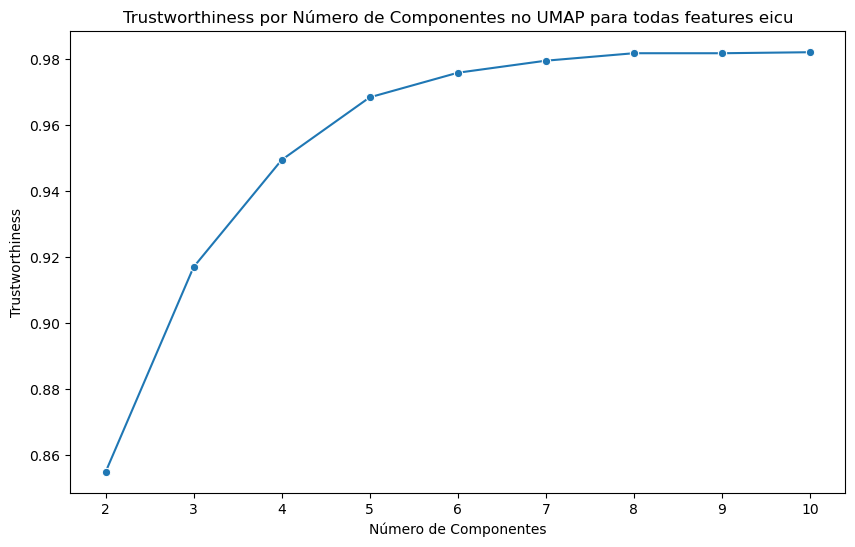

/home/grad/ccomp/23/haniel.botelho/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/grad/ccomp/23/haniel.botelho/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/grad/ccomp/23/haniel.botelho/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/grad/ccomp/23/haniel.botelho/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1945: Us

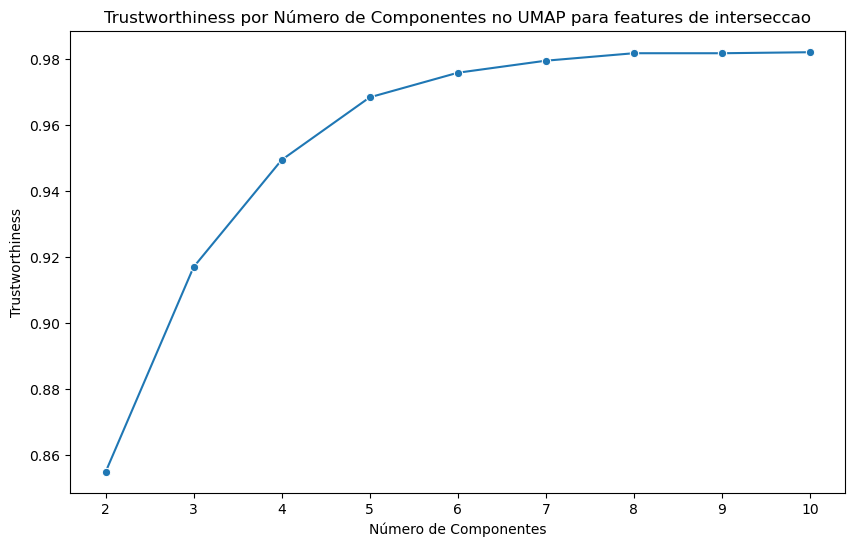

/home/grad/ccomp/23/haniel.botelho/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [92]:
reduzindo_umap(final_data,'todas features eicu')
reduzindo_umap(df_interseccao,'features de interseccao')
reducer = umap.UMAP(n_components=6, random_state=42)
final_data_missforest_umap = reducer.fit_transform(final_data)
final_data_missforest_umap_interseccao = reducer.fit_transform(df_interseccao)

##### T-SNE

In [19]:
reducer = TSNE(n_components=3, random_state=42)
final_data_missforest_tsne = reducer.fit_transform(final_data)
final_data_missforest_tsne_interseccao = reducer.fit_transform(df_interseccao)

#### Salvando

In [20]:
def save(final_data,name):
    reduced_df = pd.DataFrame(final_data, columns=[f'Component_{i+1}' for i in range(final_data.shape[1])])
    file_name = f"{name}.csv"
    reduced_df.to_csv(file_name, index=False)
    return reduced_df

In [ ]:
save(final_data_missforest_tsne, "final_data_missforest_tsne")
save(final_data_missforest_umap, "final_data_missforest_umap")
save(final_data_missforest_tsne_interseccao, "final_data_missforest_tsne_interseccao")
save(final_data_missforest_umap_interseccao, "final_data_missforest_umap_interseccao")

#### K-means

In [ ]:
# Lista de DataFrames e seus prefixos
dfs = [
    (final_data_missforest_tsne, "MissForest_tSNE"),
    (final_data_missforest_tsne_interseccao, "MissForest_tSNE_interseccao"),
    (final_data_missforest_umap, "MissForest_UMAP"),
    (final_data_missforest_umap_interseccao, "MissForest_UMAP_interseccao"),]

# Armazenar todos os DataFrames de métricas em uma lista
all_metrics_dfs = []

for df, name_prefix in dfs:
    metrics_df = generate_metrics(df, name_prefix)
    all_metrics_dfs.append(metrics_df)

# Concatenar todos os DataFrames de métricas em um único DataFrame
final_metrics_df = pd.concat(all_metrics_dfs, ignore_index=True)


final_metrics_df

In [24]:
final_metrics_df.to_csv("final_metrics.csv",index =False)

In [26]:
final_metrics_df = pd.read_csv("final_metrics.csv")

In [ ]:
print(final_metrics_df.to_markdown())

##### Melhor resultado

In [29]:
final_data_missforest_umap_interseccao = pd.read_csv("final_data_missforest_umap_interseccao.csv")
final_data_missforest_umap = pd.read_csv("final_data_missforest_umap.csv")
results = pd.read_csv("./eicu/data_imputed.csv")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import umap
from sklearn.cluster import KMeans
def plot_kmeans(df,df_reduzido,clusters,tipo)
    # Supondo que `final_data_missforest_umap` seja seu DataFrame de dados
    # Definição dos clusters e redução dimensional (já feito anteriormente)
    kmeans = KMeans(n_clusters=clusters, random_state=42)
    clusters = kmeans.fit_predict(df_reduzido)

    # Adicionar a coluna de clusters ao DataFrame original
    df[f'{tipo} Cluster'] = clusters

    # Reduzir a dimensionalidade para 2 componentes usando UMAP
    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    reduced_data = umap_reducer.fit_transform(df_reduzido)

    # Converter os dados reduzidos para um DataFrame
    reduced_df = pd.DataFrame(reduced_data, columns=['Component_1', 'Component_2'])
    reduced_df['Cluster'] = clusters

    # Definir rótulos para os clusters
    cluster_labels = {0: 'Subfenótipo A', 1: 'Subfenótipo B', 1: 'Subfenótipo B', 2: 'Subfenótipo C'}

    # Mapear os números dos clusters para os rótulos
    reduced_df['Cluster_Label'] = reduced_df['Cluster'].map(cluster_labels)

    # Plotar os clusters
    plt.figure(figsize=(10, 8))

    # Plotar os pontos com cores diferentes para cada cluster
    scatter = plt.scatter(
        reduced_df['Component_1'], 
        reduced_df['Component_2'], 
        c=reduced_df['Cluster'], 
        cmap='viridis', 
        marker='o'
    )

    # Adicionar uma legenda personalizada
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(c)), markersize=10, label=label) for c, label in cluster_labels.items()]
    plt.legend(handles=handles, title=f'Subfenótipos das features: {}')

    # Adicionar labels e título
    plt.xlabel('Componente principal 1')
    plt.ylabel('Componente principal 2')

    # Exibir o gráfico
    plt.show()

plot_kmeans(results,final_data_missforest_umap_interseccao,3,'interseccao')
plot_kmeans(results,final_data_missforest_umap,2,'todas')

In [31]:
results.to_csv("final_clusters_kmeans.csv",index=False)

In [41]:
exams_columns = ['age', 'bands', 'CRP', 'ESR', 'temp', 'lactate',
       'WBC', 'lymphs', 'resp', 'spo2/fio2', 'pao2/fio2', 'bicarbonate',
       'heartRate', 'troponin', 'systolic', 'diastolic', 'MAP',
       'bloodUreaNitrogen', 'alanine', 'aspartate', 'bilirubin', 'hemoglobin',
       'iqr', 'platelets', 'PTT', 'fibrinogen', 'albumin', 'chloride',
       'glucose', 'sodium', 'gcs', 'potassium', 'calcium', 'phosphate',
       'magnesium', 'sofascore']

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dicionário de tradução dos nomes das colunas
translation_dicto = {
    'age': 'idade',
    'bands': 'bastonetes',
    'CRP': 'PCR',  # Proteína C Reativa
    'ESR': 'VHS',  # Velocidade de Hemossedimentação
    'temp': 'temperatura',
    'lactate': 'lactato',
    'WBC': 'leucócitos',
    'lymphs': 'linfócitos',
    'resp': 'frequência_respiratória',
    'spo2/fio2': 'spo2/fio2',  # Relação entre Saturação de Oxigênio e Fração de Oxigênio Inspirado
    'pao2/fio2': 'pao2/fio2',  # Relação entre Pressão Parcial de Oxigênio e Fração de Oxigênio Inspirado
    'bicarbonate': 'bicarbonato',
    'heartRate': 'frequência_cardíaca',
    'troponin': 'troponina',
    'systolic': 'pressão_sistólica',
    'diastolic': 'pressão_diastólica',
    'MAP': 'PAM',  # Pressão Arterial Média
    'bloodUreaNitrogen': 'ureia',
    'alanine': 'alanina',
    'aspartate': 'aspartato',
    'bilirubin': 'bilirrubina',
    'hemoglobin': 'hemoglobina',
    'iqr': 'amplitude_interquartílica',
    'platelets': 'plaquetas',
    'PTT': 'TTPa',  # Tempo de Tromboplastina Parcial Ativada
    'fibrinogen': 'fibrinogênio',
    'albumin': 'albumina',
    'chloride': 'cloro',
    'glucose': 'glicose',
    'sodium': 'sódio',
    'gcs': 'escala_de_coma_de_Glasgow',
    'potassium': 'potássio',
    'calcium': 'cálcio',
    'phosphate': 'fosfato',
    'magnesium': 'magnésio',
    'sofascore': 'pontuação_SOFA',
    'gender_Female': 'sexo_Feminino',
    'gender_Male': 'sexo_Masculino',
    'gender_Unknown': 'sexo_Desconhecido',
    'ethnicity_African American': 'etnia_Afro-Americana',
    'ethnicity_Asian': 'etnia_Asiática',
    'ethnicity_Caucasian': 'etnia_Caucasiana',
    'ethnicity_Hispanic': 'etnia_Hispânica',
    'ethnicity_Native American': 'etnia_Nativo-Americana',
    'ethnicity_Other/Unknown': 'etnia_Outra/Desconhecida'
}


# Dicionário para substituir números por letras no eixo x
x_labels_dict = {i: chr(65 + i) for i in range(16)}

max_plots_per_figure = 16

# Função para plotar boxplots com largura proporcional
def plot_boxplots(df, columns, translation_dict, x_labels_dict, max_plots_per_figure):
    num_columns = len(columns)
    num_figures = (num_columns + max_plots_per_figure - 1) // max_plots_per_figure  # Calcula o número de figuras necessárias
    
    for i in range(num_figures):
        plt.figure(figsize=(20, 15))
        start = i * max_plots_per_figure
        end = min(start + max_plots_per_figure, num_columns)
        
        for j, column in enumerate(columns[start:end]):
            plt.subplot((max_plots_per_figure // 4) + 1, 4, j + 1)
            
            # Transformar o DataFrame em formato longo
            df_long = df.melt(id_vars=['Cluster'], value_vars=[column], 
                              var_name='Exam', value_name='Value')
            
            # Calcular o número de amostras por cluster
            sample_counts = df_long.groupby('Cluster').size().reset_index(name='Count')
            
            # Merge as contagens com o DataFrame longo
            df_long = pd.merge(df_long, sample_counts, on='Cluster')
            
            # Calcular a largura das caixas com base na quantidade de dados
            df_long['Width'] = df_long['Count'] / df_long['Count'].max()
            
            # Plotar o box plot com largura proporcional
            sns.boxplot(x='Cluster', y='Value', data=df_long,
                        width=df_long['Width'].mean())  # Define a largura média para o box plot
            
            # Ajustar os rótulos do eixo x
            plt.xticks(ticks=range(len(df_long['Cluster'].unique())), 
                       labels=[x_labels_dict.get(i, i) for i in range(len(df_long['Cluster'].unique()))])
            
            plt.title(translation_dict.get(column, column))
            plt.xlabel('')
            plt.ylabel('')
        
        plt.tight_layout()
        plt.show()

# Definição das colunas de exames

# Plotar os boxplots
plot_boxplots(results, exams_columns, translation_dicto, x_labels_dict, max_plots_per_figure)


In [55]:
results['Gender'] = results[['gender_Female', 'gender_Male', 'gender_Unknown']].idxmax(axis=1)
results['Gender'] = results['Gender'].str.replace('gender_', '')

# Combina as colunas de etnia em uma única coluna
results['Ethnicity'] = results[['ethnicity_African American','ethnicity_Asian','ethnicity_Caucasian','ethnicity_Hispanic','ethnicity_Native American','ethnicity_Other/Unknown']].idxmax(axis=1)
results['Ethnicity'] = results['Ethnicity'].str.replace('ethnicity_', '')

In [ ]:
# Definir as colunas categóricas
categorical_columns = ['Ethnicity', 'Gender']

# Função para calcular a frequência das categorias para cada cluster
def calculate_frequency(df, categorical_columns):
    frequency_dfs = {}
    for column in categorical_columns:
        freq_df = df.groupby(['Cluster', column]).size().unstack(fill_value=0)
        frequency_dfs[column] = freq_df
    return frequency_dfs

# Calcular a frequência das categorias
frequency_dfs = calculate_frequency(results, categorical_columns)

# Plotar as frequências
def plot_frequencies(frequency_dfs):
    for column, freq_df in frequency_dfs.items():
        plt.figure(figsize=(12, 6))
        freq_df.plot(kind='bar', stacked=True, colormap='viridis')
        plt.title(f'Frequência de {column} por Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Frequência')
        plt.legend(title=column)
        plt.show()

# Plotar as frequências
plot_frequencies(frequency_dfs)

#### GMM

In [38]:
final_data_missforest_tsne =  pd.read_csv("final_data_missforest_tsne.csv")
#final_data_knn_tsne = pd.read_csv("final_data_knn_tsne.csv")
final_data_missforest_umap =  pd.read_csv("final_data_missforest_umap.csv")
#final_data_knn_umap =  pd.read_csv("final_data_knn_umap.csv")

In [ ]:
# Lista de DataFrames e seus prefixos

dfs = [
    (final_data_missforest_tsne, "MissForest_tSNE"),
    (final_data_missforest_umap, "MissForest_UMAP")
    ]

# Armazenar todos os DataFrames de métricas em uma lista
all_metrics_dfs = []

for df, name_prefix in dfs:
    metrics_df = generate_gmm_metrics(df, name_prefix)
    all_metrics_dfs.append(metrics_df)

# Concatenar todos os DataFrames de métricas em um único DataFrame
final_metrics_df = pd.concat(all_metrics_dfs, ignore_index=True)


final_metrics_df

In [32]:

def evaluate_gmm_parameters(df, name_prefix):
    # Definindo os parâmetros a serem avaliados
    param_grid = {
        'n_components': range(2, 11),  # Testando de 2 a 10 componentes
        'covariance_type': ['full', 'tied', 'diag', 'spherical'],  # Diferentes tipos de covariância
        'init_params': ['kmeans', 'random'],  # Métodos de inicialização
    }
    
    # Armazenar os resultados
    results = {
        'n_components': [],
        'covariance_type': [],
        'init_params': [],
        'Silhouette Score': [],
        'BIC': []
    }

    # Avaliação dos parâmetros
    for n_components in param_grid['n_components']:
        for covariance_type in param_grid['covariance_type']:
            for init_params in param_grid['init_params']:
                gmm = GaussianMixture(
                    n_components=n_components,
                    covariance_type=covariance_type,
                    init_params=init_params,
                    random_state=42
                )
                gmm.fit(df)
                labels = gmm.predict(df)
                
                # Calcular o Silhouette Score
                if len(np.unique(labels)) > 1:  # Silhouette Score requer pelo menos 2 clusters distintos
                    silhouette = silhouette_score(df, labels)
                else:
                    silhouette = np.nan
                
                # Calcular o BIC
                bic = gmm.bic(df)
                
                # Armazenar os resultados
                results['n_components'].append(n_components)
                results['covariance_type'].append(covariance_type)
                results['init_params'].append(init_params)
                results['Silhouette Score'].append(silhouette)
                results['BIC'].append(bic)
    
    # Criar DataFrame com os resultados
    results_df = pd.DataFrame(results)
    results_df['Dataset'] = name_prefix
    
    # Exibir os melhores parâmetros com base no Silhouette Score
    best_silhouette = results_df.loc[results_df['Silhouette Score'].idxmax()]
    print("Melhores parâmetros com base no Silhouette Score:")
    print(best_silhouette)
    
    # Exibir os melhores parâmetros com base no BIC
    best_bic = results_df.loc[results_df['BIC'].idxmin()]
    print("\nMelhores parâmetros com base no BIC:")
    print(best_bic)
    
    # Plot do Silhouette Score para diferentes combinações de parâmetros
    plt.figure(figsize=(12, 6))
    plt.plot(results['n_components'], results['Silhouette Score'], 'o-', label='Silhouette Score', color='blue')
    plt.xlabel('Número de Componentes')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score para Diferentes Parâmetros - {name_prefix}')
    plt.legend()
    plt.show()
    
    return results_df

In [ ]:
gmm_results = evaluate_gmm_parameters(final_data_missforest_umap, "MissForest_UMAP")

##### Melhor resultado

In [49]:
final_data_missforest_umap_interseccao = pd.read_csv("final_data_missforest_umap_interseccao.csv")
final_data_missforest_umap = pd.read_csv("final_data_missforest_umap.csv")
results = pd.read_csv("./eicu/data_imputed.csv")

In [ ]:
def plot_gmm(gmm,tipo,df,df_reduzido):
    mm.fit(df_reduzido)
    clusters_gmm = gmm.predict(df_reduzido)
    # Adicionar a coluna de clusters ao DataFrame original
    results['Cluster'] = clusters_gmm

    # Reduzir a dimensionalidade para 2 componentes usando UMAP para visualização
    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    reduced_data = umap_reducer.fit_transform(df_reduzido)

    # Converter os dados reduzidos para um DataFrame
    reduced_df = pd.DataFrame(reduced_data, columns=['Component_1', 'Component_2'])
    df[f'{tipo} Cluster'] = clusters_gmm

    # Plotar os clusters
    plt.figure(figsize=(10, 8))

    # Plotar os pontos com cores diferentes para cada cluster
    scatter = plt.scatter(
        reduced_df['Component_1'], 
        reduced_df['Component_2'], 
        c=reduced_df['Cluster'], 
        cmap='viridis', 
        marker='o'
    )

    # Adicionar uma barra de cores
    plt.colorbar(scatter, label='Cluster')

    # Adicionar labels e título
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.title(f'Clusters Identificados pelo GMM das features {tipo}')

    # Exibir o gráfico
    plt.show()

In [ ]:
gmm2 = GaussianMixture(n_components=3, random_state=42,covariance_type='spherical',init_params='random')
gmm1 = GaussianMixture(n_components=2, random_state=42,covariance_type='tied')

plot_gmm(gmm2, 'interseccao',results,final_data_missforest_umap_interseccao)
plot_gmm(gmm1, 'todas', results,final_data_missforest_umap)

In [37]:
results.to_csv('final_clusters_gmm.csv',index=False)

In [ ]:
max_plots_per_figure = 16

# Função para plotar boxplots
def plot_boxplots(df, columns, max_plots_per_figure):
    num_columns = len(columns)
    num_figures = (num_columns + max_plots_per_figure - 1) // max_plots_per_figure  # Calcula o número de figuras necessárias
    
    for i in range(num_figures):
        plt.figure(figsize=(20, 15))
        start = i * max_plots_per_figure
        end = min(start + max_plots_per_figure, num_columns)
        
        for j, column in enumerate(columns[start:end]):
            plt.subplot((max_plots_per_figure // 4) + 1, 4, j + 1)
            sns.boxplot(x='Cluster', y=column, data=df)
            plt.title(column)
            plt.xlabel('')
            plt.ylabel('')
        
        plt.tight_layout()
        plt.show()

# Plotar os boxplots
plot_boxplots(results, exams_columns, max_plots_per_figure)

In [ ]:
results.columns

In [ ]:
# Definir as colunas categóricas
categorical_columns = ['Ethnicity', 'Gender']

# Função para calcular a frequência das categorias para cada cluster
def calculate_frequency(df, categorical_columns):
    frequency_dfs = {}
    for column in categorical_columns:
        freq_df = df.groupby(['Cluster', column]).size().unstack(fill_value=0)
        frequency_dfs[column] = freq_df
    return frequency_dfs

# Calcular a frequência das categorias
frequency_dfs = calculate_frequency(results, categorical_columns)

# Plotar as frequências
def plot_frequencies(frequency_dfs):
    for column, freq_df in frequency_dfs.items():
        plt.figure(figsize=(12, 6))
        freq_df.plot(kind='bar', stacked=True, colormap='viridis')
        plt.title(f'Frequência de {column} por Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Frequência')
        plt.legend(title=column)
        plt.show()

# Plotar as frequências
plot_frequencies(frequency_dfs)